# Introduction to Theano

This notebook contains the code snippets from the slides, so you can execute them and tinker with those examples.

To execute a cell: Ctrl-Enter.

The code was executed with the default configuration of Theano: `floatX=float64`, `device=cpu`. Force this configuration, by executing the following cell.

In [1]:
import os
os.environ['THEANO_FLAGS'] = 'floatX=float64,device=cpu'

# Theano concepts

## Symbolic inputs

The symbolic inputs that you operate on are **Variables** and what you get from applying various **Ops** to these inputs are also Variables. A Variable is the main data structure you work with. A **Type** in Theano represents a set of constraints on potential data objects. These constraints allow Theano to tailor C code to handle them and to statically optimize the computation graph. The Type of both `x` and `y` is `vector`. Here is [the complete list of types](http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors).

In [2]:
import numpy as np
import theano
import theano.tensor as T
x = T.dmatrix('x')
y = T.dmatrix('y')

## Operation

An **Op** defines a certain computation on some types of inputs, producing some types of outputs. From a list of input Variables and an Op, you can build an **Apply** node representing the application of the Op to the inputs.

An Apply node is a type of internal node used to represent a computation graph.
It represents the application of an Op on one or more inputs, where each input is a Variable. By convention, each Op is responsible for knowing how to build an Apply node from a list of inputs.

In [3]:
z = x + y

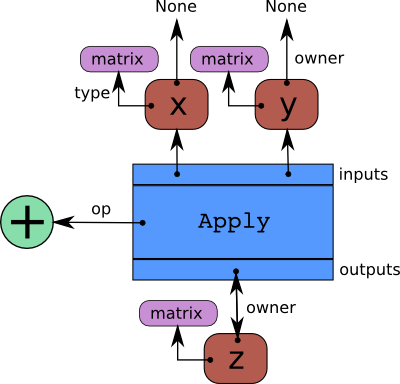

## Functions

`theano.function` is the interface for compiling graphs into callable objects. When `theano.function` is executed, the computation graph is optimized and theano generates an efficient code in C (with calls to CUDA if the gpu flag is set). This is totally transparent to the user, except for the different compilation modes.
The mode argument controls the sort of optimizations that will be applied to the graph, and the way the optimized graph will be evaluated. These modes are:
- `FAST_COMPILE`: Apply just a few graph optimizations and only use Python implementations. So GPU is disabled.

- `FAST_RUN`: Apply all optimizations and use C implementations where possible.

- `DebugMode`: Verify the correctness of all optimizations, and compare C and Python implementations. This mode can take much longer than the other modes, but can identify several kinds of problems.

The default is typically `FAST_RUN` but this can be changed in `theano.config.mode`.

In [4]:
a = np.random.randn(1, 3)
b = np.random.randn(1, 3)

# theano.function([inputs], [outputs])
f = theano.function([x, y], z)
f(a,b)

array([[ 2.12702008,  2.04145691,  2.36353814]])

## Shared variables

A **Shared Variable** is a hybrid symbolic and non-symbolic variable whose value may be shared between multiple functions. Shared variables can be used in symbolic expressions but they also have an internal value that defines the value taken by this symbolic variable in all the functions that use it. It is called a shared variable because its value is shared between many functions. The value can be accessed and modified by the .get_value() and .set_value() methods.

In [5]:
import numpy as np
np.random.seed(42)

W_val = np.random.randn(4, 3)
b_val = np.ones(3)

W = theano.shared(W_val)
b = theano.shared(b_val)

W.name = 'W'
b.name = 'b'

In [6]:
print(W.get_value())
print('Before ', b.get_value())
# b.set_value(1) --  Type error, must be a numpy array of shape (3,)
# b.set_value(np.array([[1,2],[3,4]])) # Type error, must be a numpy array of shape (3,)
b.set_value(np.array([1,2,3]))
print('After ', b.get_value())

[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975]]
Before  [ 1.  1.  1.]
After  [ 1.  2.  3.]


## Shared variables and functions

Shared variables can be used to represent an internal state of a function. In order to modify this internal state, the function has an argument called `updates`, which takes an iterable over pairs (shared_variable, new_expression) List, tuple or dict.

Note in the following that `state` is an implicit input of the function `accumulator`.

In [7]:
state = theano.shared(0)
inc = T.iscalar('inc')
accumulator = theano.function([inc], state, updates=[(state, state+inc)])

The function is evaluated and then, the update mechanism is executed.

In [8]:
print('First call to accumulator {}:'.format(accumulator(1)))
print('Second call to accumulator {}:'.format(accumulator(10)))
print('Third call to accumulator {}:'.format(accumulator(100)))

First call to accumulator 0:
Second call to accumulator 1:
Third call to accumulator 11:


## A regression toy example
### Build a simple model
The following is a simple linear transformation (out = Wx +b) followed by a nonlinearity (theano.sigmoid).

In [9]:
x = T.vector('x')
y = T.vector('y')

W_val = np.random.randn(4, 3)
b_val = np.ones(3)
W = theano.shared(W_val)
b = theano.shared(b_val)
W.name = 'W'
b.name = 'b'

dot = T.dot(x, W)
out = T.nnet.sigmoid(dot + b)

predict = theano.function([x], out)
x_val = np.random.rand(4)
print(predict(x_val))

[ 0.62879664  0.26366144  0.65480407]


In order to train the model, we define a cost function that will evaluate how far the model is from the target.

In [10]:
C = ((out - y) ** 2).sum()
C.name = 'C'
error = theano.function([out, y], C)

y_val = np.random.uniform(size=3)
print(error([0.942, 0.737, 0.676], y_val))

0.8978207040456921


## Automatic differentiation

Now that the graph is defined, we can compute the gradient of the cost C w.r.t some parameters (W,b). The gradient must be applied to a scalar expression, e.g., the cost C.

In [11]:
# theano.grad(exp, [Variable])
dC_dW, dC_db = theano.grad(C, [W, b])

Now that we can compute the gradients, we define the gradient descent update rule.

In [12]:
upd_W = W - 1 * dC_dW
upd_b = b - 1 * dC_db

Finally, we compile the expressions and the update rules.

In [13]:
train = theano.function([x, y], C,
                        updates=[(W, upd_W),
                                 (b, upd_b)])
print(b.get_value())
print(W.get_value())

[ 1.  1.  1.]
[[ 0.24196227 -1.91328024 -1.72491783]
 [-0.56228753 -1.01283112  0.31424733]
 [-0.90802408 -1.4123037   1.46564877]
 [-0.2257763   0.0675282  -1.42474819]]


We iterate the gradient descent update rule in order to minimize the cost.

In [14]:
for i in range(25):
    C = train(x_val, y_val)
    print('Cost {:} at iteration {}'.format(C,i))
print(b.get_value())
print(W.get_value())

Cost 0.8839545632185406 at iteration 0
Cost 0.613055836442672 at iteration 1
Cost 0.3949836749908535 at iteration 2
Cost 0.25302798495948353 at iteration 3
Cost 0.1712113712962826 at iteration 4
Cost 0.12371670556342695 at iteration 5
Cost 0.0943053420124276 at iteration 6
Cost 0.07482420308641158 at iteration 7
Cost 0.0611804722274652 at iteration 8
Cost 0.05119359469703345 at iteration 9
Cost 0.04362302108607826 at iteration 10
Cost 0.037720392009106304 at iteration 11
Cost 0.033011244039859285 at iteration 12
Cost 0.029181930086006263 at iteration 13
Cost 0.02601767834583368 at iteration 14
Cost 0.023366954842625614 at iteration 15
Cost 0.02112006504220001 at iteration 16
Cost 0.019195819635426478 at iteration 17
Cost 0.017532952186818287 at iteration 18
Cost 0.01608443625512211 at iteration 19
Cost 0.014813627026008087 at iteration 20
Cost 0.0136915828209778 at iteration 21
Cost 0.012695168417730246 at iteration 22
Cost 0.011805687845568898 at iteration 23
Cost 0.01100788288075237 

# Visualization and debugging
## Graph visualization
### Comparing `out` with `predict`

In [15]:
from theano.printing import pydotprint
from IPython.display import Image, SVG

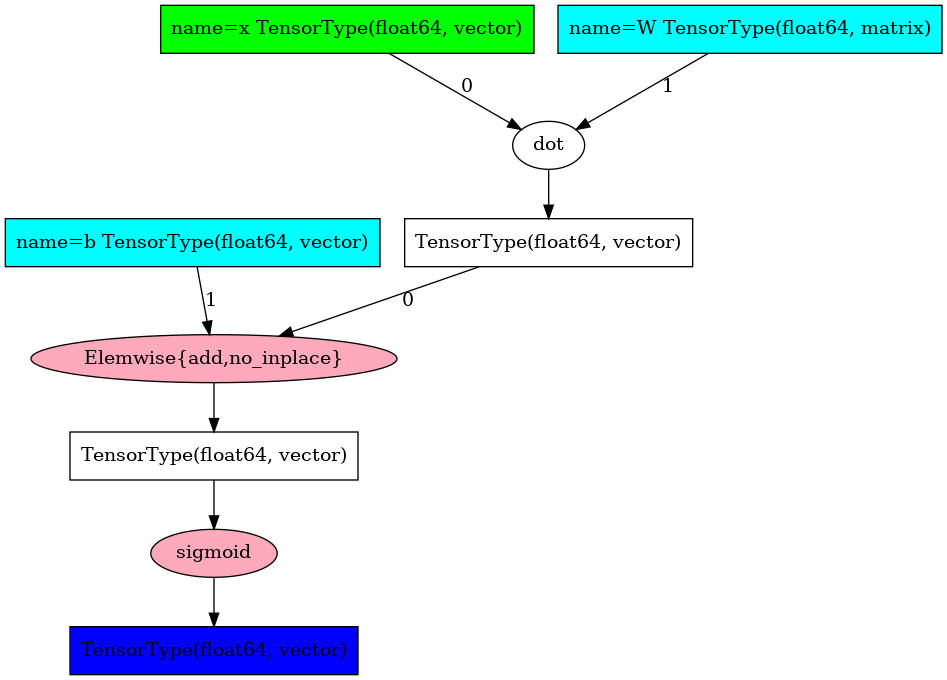

In [16]:
Image(pydotprint(out, format='png', compact=False, return_image=True))

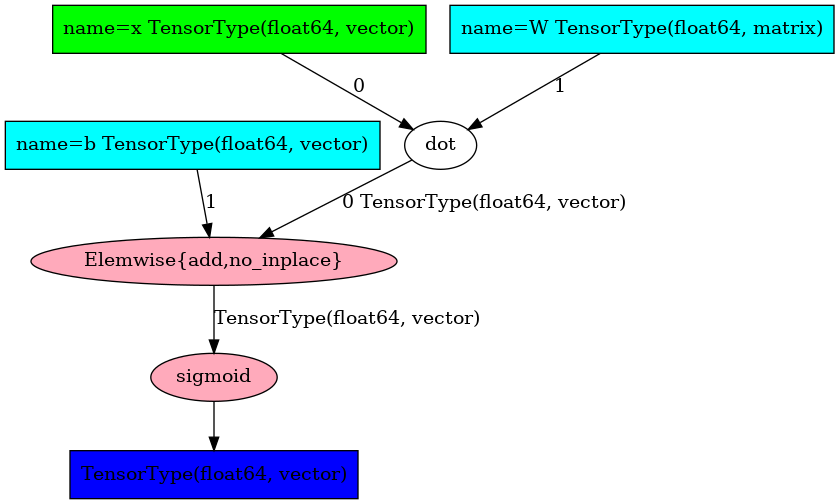

In [17]:
Image(pydotprint(out, format='png', return_image=True))

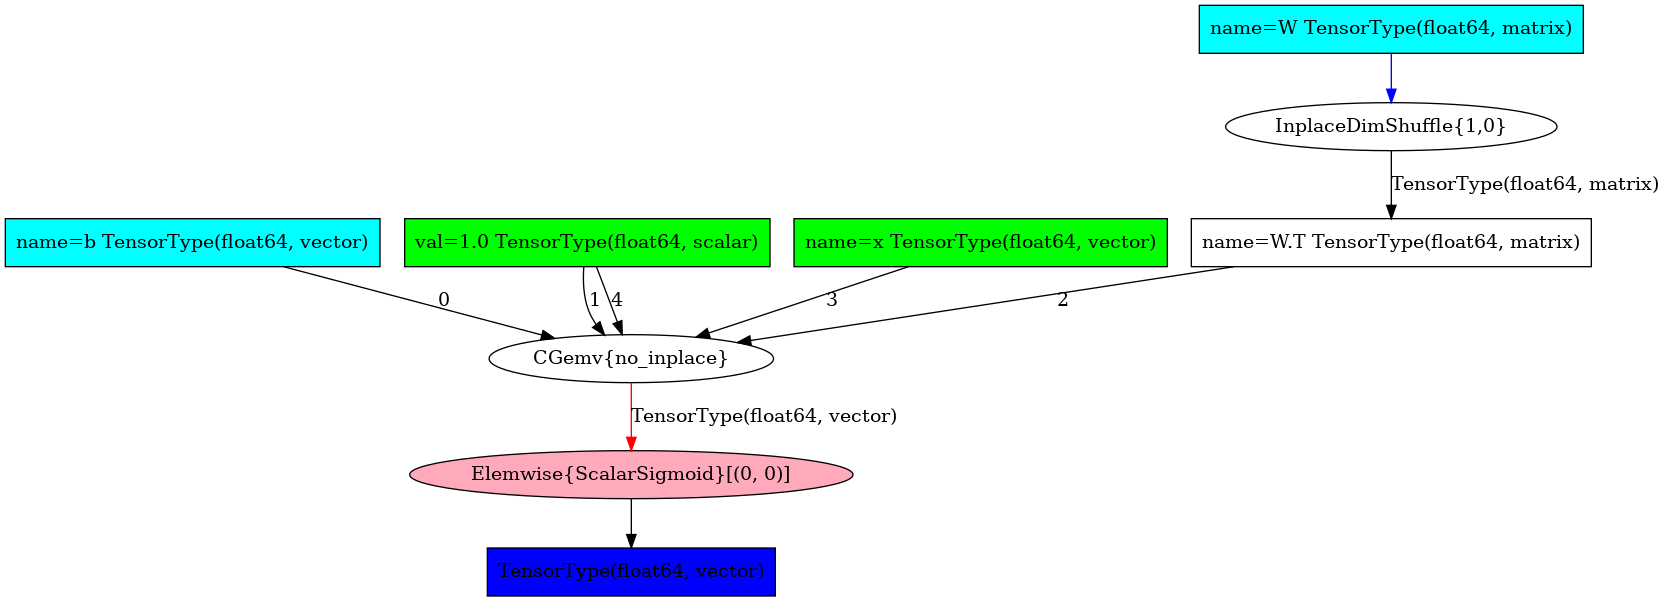

In [18]:
Image(pydotprint(predict, format='png', return_image=True))

### Comparing `upd_*` with `train`

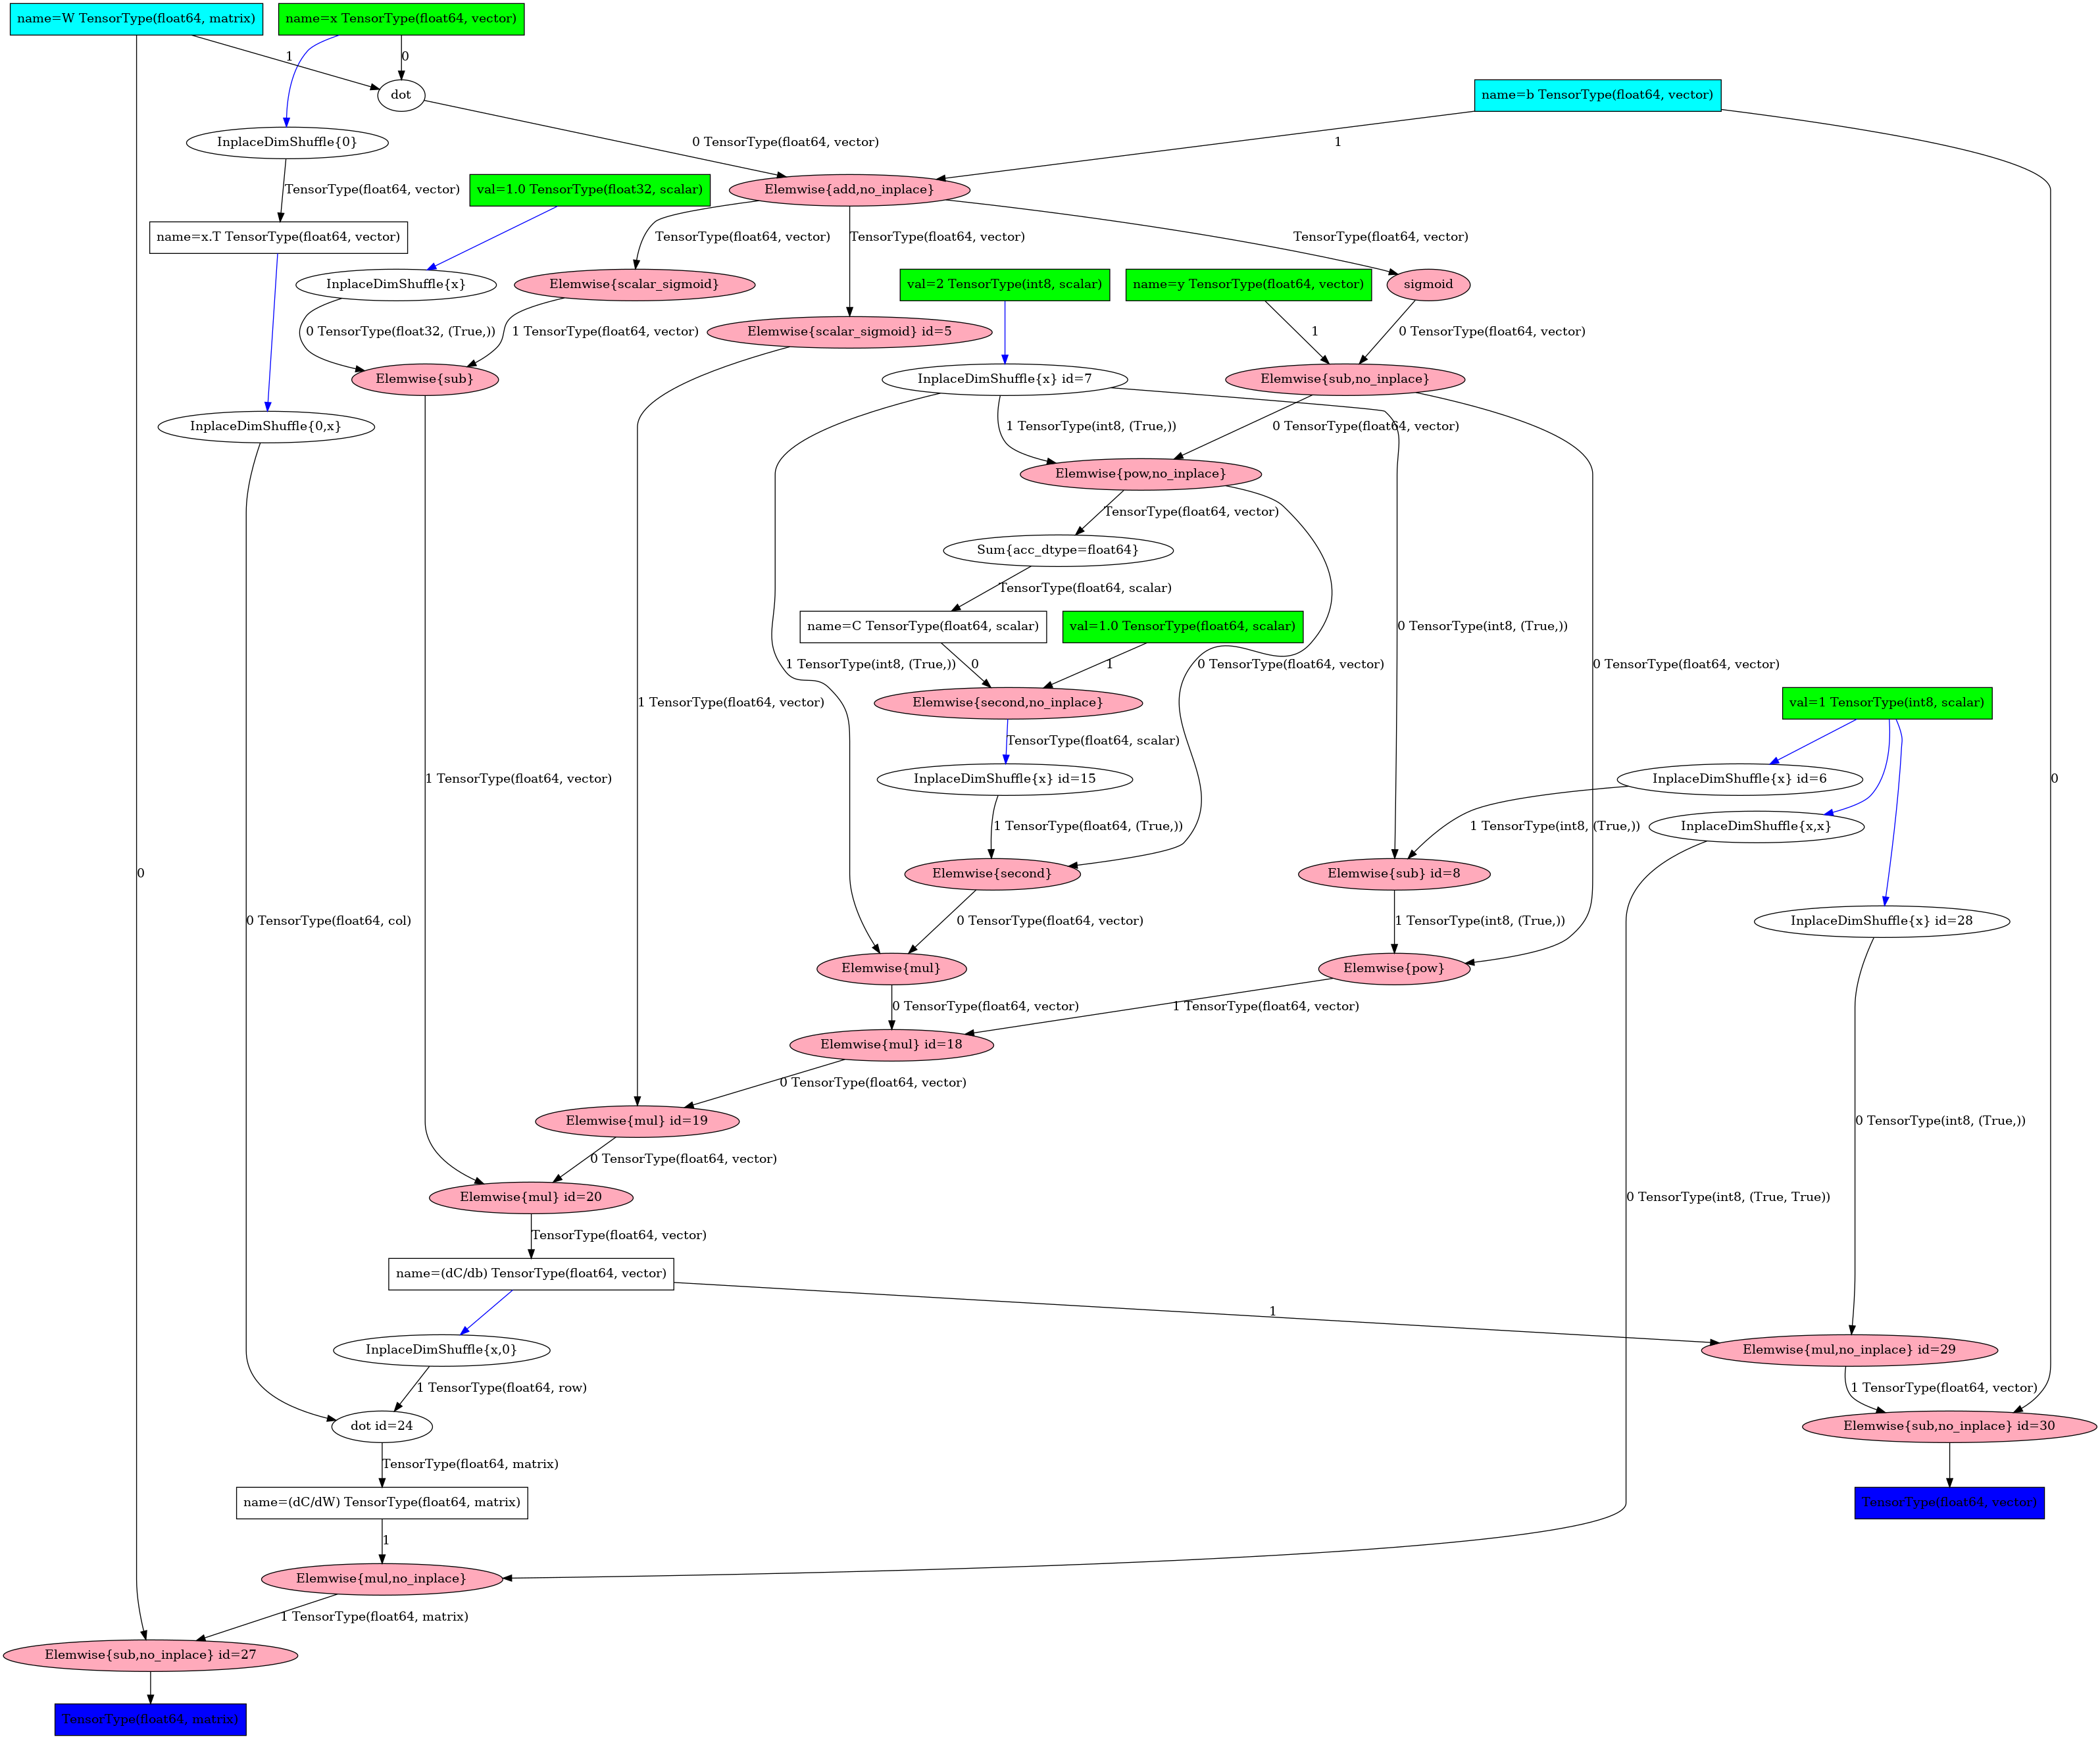

In [19]:
Image(pydotprint([upd_W, upd_b], format='png', return_image=True), width=1000)

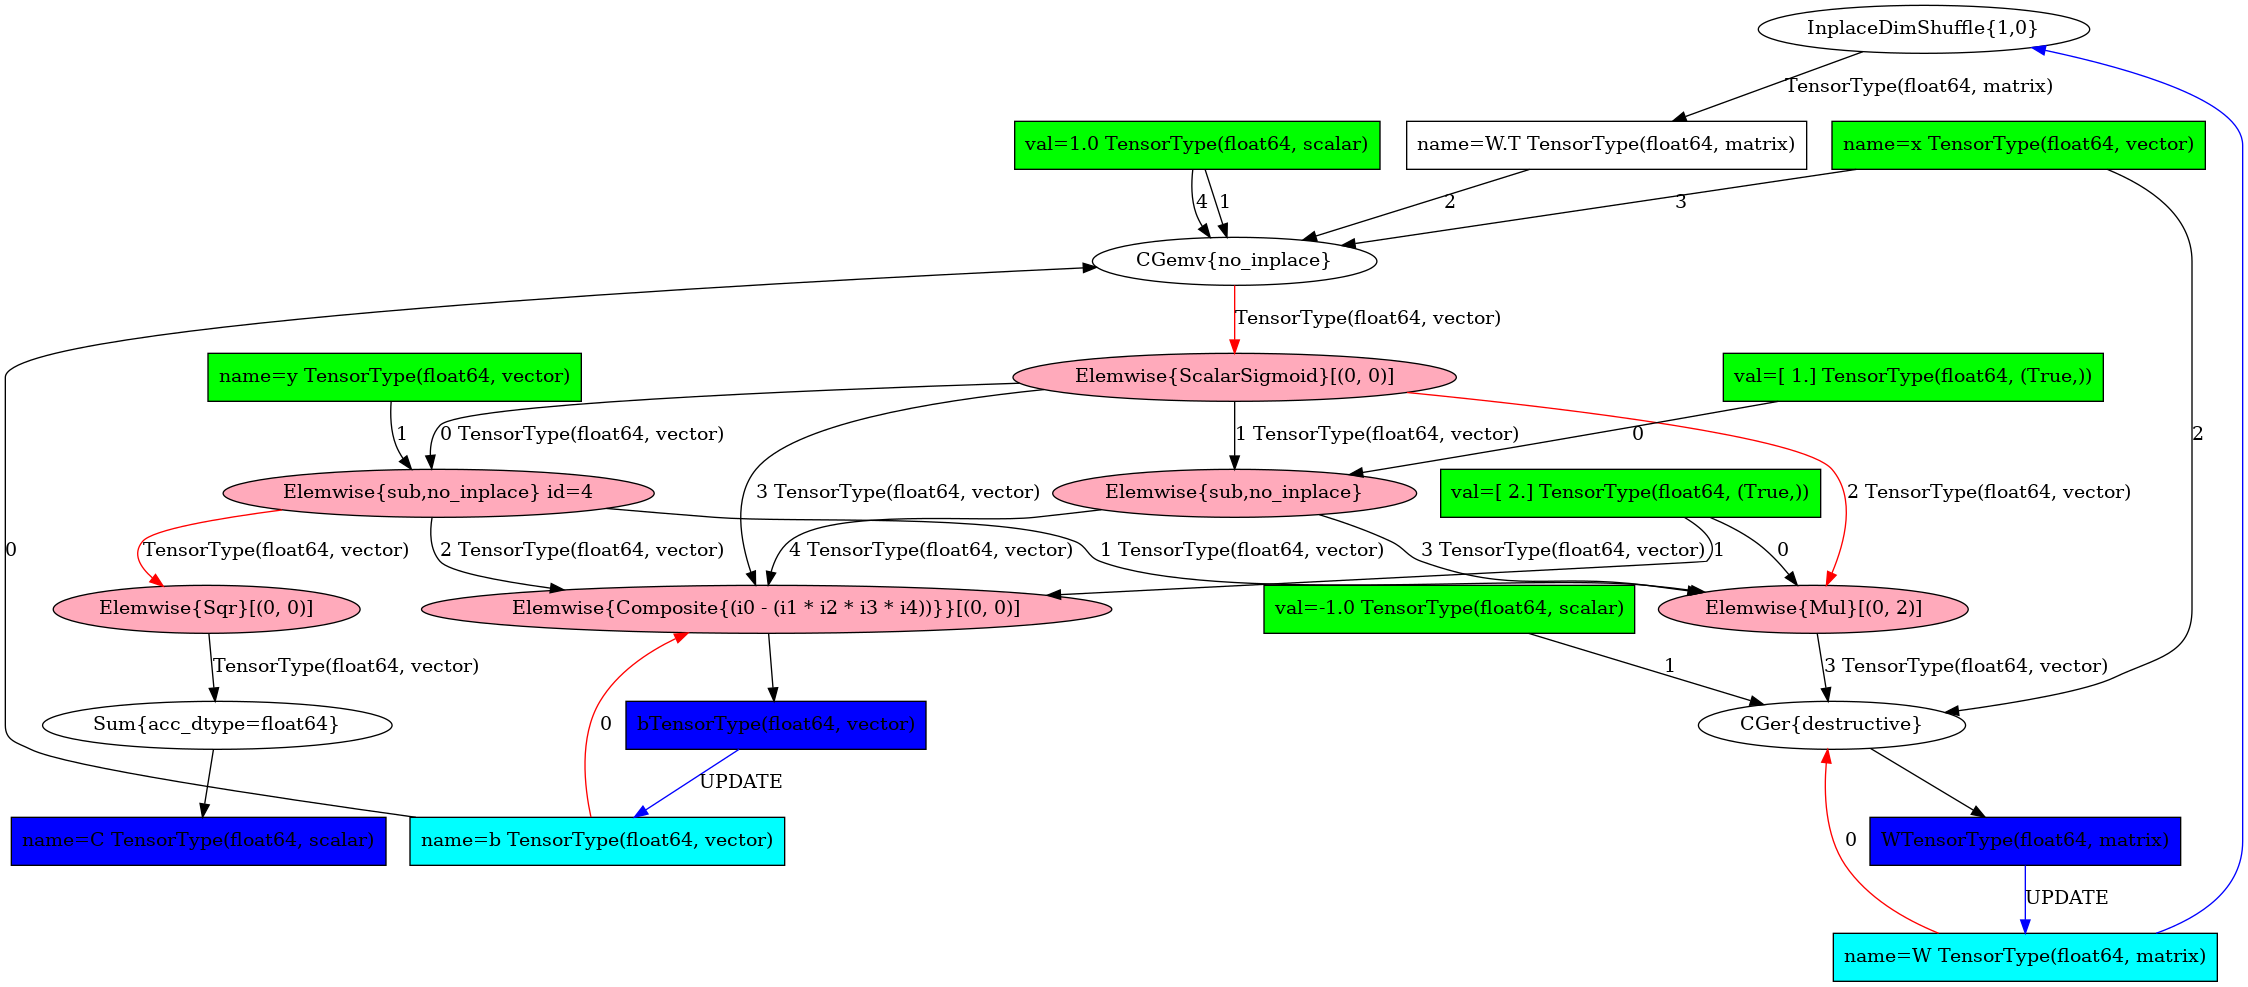

In [20]:
Image(pydotprint(train, format='png', return_image=True), width=1000)

### `debugprint`

In [21]:
from theano.printing import debugprint
debugprint(out)

sigmoid [id A] ''   
 |Elemwise{add,no_inplace} [id B] ''   
   |dot [id C] ''   
   | |x [id D]
   | |W [id E]
   |b [id F]


In [22]:
debugprint(predict)

Elemwise{ScalarSigmoid}[(0, 0)] [id A] ''   2
 |CGemv{no_inplace} [id B] ''   1
   |b [id C]
   |TensorConstant{1.0} [id D]
   |InplaceDimShuffle{1,0} [id E] 'W.T'   0
   | |W [id F]
   |x [id G]
   |TensorConstant{1.0} [id D]
